# CNN特征提取结果可视化——hooks简单应用



在神经网络搭建时可能出现各式各样的错误，使用hook而非print或者简单的断点调试有助于你更清晰的意识到错误所在。

hook的使用场景多种多样，本文将使用hooks来简单可视化卷积神经网络的特征提取。用到的神经网络框架为**Pytorch**


## Hooks简单介绍


每个hook都是预先定义好的可调用对象，在pytorch框架中，每个``nn.Module``对象都能够方便地注册（定义）一个hook。当一些trigger方法调用（如`forward()`和`backward()`）后，注册了hook的`nn.Module`对象会将相关信息传递到hook里面去。
在PyTorch中，可以注册三种hook：
1. forward prehook (在forward之前执行）
2. forward hook (在forward之后执行)
3. backward hook (在backward之后执行)

具体理解每种hook的使用不是本文讨论的范围，我们将通过一个生动的卷积神经网络可视化例子来介绍hook的使用

## 可视化准备工作


我们将要进行的工作包括：
1. 创建CNN特征提取器，本文使用PyTorch自带的resnet34
2. 创建一个保存hook内容的对象
3. 为每个卷积层创建hook
4. 导入需要使用的库

本文将对下图进行特征提取并可视化
<center>
<img src="https://img-blog.csdnimg.cn/20210410111323237.jpg" width=50%>
</center>
(地址为"https://img-blog.csdnimg.cn/20210410111323237.jpg")

### 用到的python库

In [37]:
import numpy as np

import torch
import torchvision
from PIL import Image
from torchvision import transforms as T

import matplotlib.pyplot as plt

### 创建CNN特征提取器

In [2]:
feature_extractor = torchvision.models.resnet34(pretrained=True)
if torch.cuda.is_available():
	feature_extractor.cuda()

device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

Downloading: "https://download.pytorch.org/models/resnet34-333f7ec4.pth" to /root/.cache/torch/hub/checkpoints/resnet34-333f7ec4.pth


### 创建保存hook内容的对象

In [3]:
class SaveOutput:
	def __init__(self):
		self.outputs = []
	def __call__(self, module, module_in, module_out):
		self.outputs.append(module_out)
	def clear(self):
		self.outputs=[]
		
save_output = SaveOutput()

### 为卷积层注册hook

In [4]:
hook_handles = []

for layer in feature_extractor.modules():
	if isinstance(layer, torch.nn.Conv2d):
		handle = layer.register_forward_hook(save_output)
		hook_handles.append(handle)

## 读取图像并进行特整体提取

In [5]:
image = Image.open('cat.jpg')
transform = T.Compose([T.Resize((224, 224)), T.ToTensor()])
X = transform(image).unsqueeze(dim=0).to(device)

out = feature_extractor(X)

## 查看卷积层特征提取效果
对于resnet来说，其具体结构如下：
<center>
<img src="https://img-blog.csdnimg.cn/2021041012222937.png" width=50%>
<center>

卷积层共有`1+6+(4*2+1)+(6*2+1)+(3*2+1)=36`个，对conv3_x层有4\*2+1卷积层的原因是（1）四个basicblock本身有4\*2个卷积层（2）其中一个basicblock进行了downsample，又多了一个卷积层

### 可视化哪些卷积层？
对于resnet34来说，我们计划可视化其第1、2、15、28个卷积层，为何如此？
* 第一个卷积层是conv1_x的输出，图片轮廓较为清楚
* 第二、七个卷积层是conv2_x首个和末尾卷积层的输出，我们将其于第一个卷积层输出对比可以得到特征逐渐高层化的结论
* 第十五个卷积层是conv3_x的输出
* 第二十八个卷积层是conv4_x的输出

**为何不可视化最后一个卷积层？**

对于最后一个卷积层，其每个通道的像素仅仅为7x7，可视化也看不出什么东西。或者说我们可视化第二十八个卷积层后，就发现继续可视化没有必要了。

### 提取计划可视化的卷积层结果

1. 每个卷积层的结果都通过hook保存到了`save_output.outputs`里面，我们查看是否为36个结果
2. 我们创建一个拼接卷积结果的函数。对每个卷积层来说，其结果都是由许多单通道图片组成（比如第一个卷积层的通道为64，因此有64张单通道图片），因此我们首先需要将这些单通道图片进行拼接一张单通道大图。
>**这里的单通道仅仅指图片通道数目为1，是否为灰度图片本人并不清楚，只是可视化时只好使用灰度图的办法显示，如果有清楚概念的小伙伴希望不吝赐教**
3. 提取计划可视化的卷积层结果

#### 临时查看
我们查看是否为36个结果并查看计划可视化的层的shape

In [76]:
print(len(save_output.outputs))
a_list = [0, 1, 6, 15, 28, 35]
for i in a_list:
    print(save_output.outputs[i].cpu().detach().squeeze(0).shape)

36
torch.Size([64, 112, 112])
torch.Size([64, 56, 56])
torch.Size([64, 56, 56])
torch.Size([128, 28, 28])
torch.Size([256, 14, 14])
torch.Size([512, 7, 7])


#### 拼接函数

In [ ]:
def grid_gray_image(imgs, each_row: int):
    '''
    imgs shape: batch * size (i.e. 64x32x32, 64 is the number of the gray images, and (32, 32) is the size of each gray image)
    '''
    row_num = imgs.shape[0]//each_row
    for i in range(row_num):
        img = imgs[i*each_row]
        img = (img - img.min()) / (img.max() - img.min())
        for j in range(1, each_row):
            tmp_img = imgs[i*each_row+j]
            tmp_img = (tmp_img - tmp_img.min()) / (tmp_img.max() - tmp_img.min())
            img = np.hstack((img, tmp_img))
        if i == 0:
            ans = img
        else:
            ans = np.vstack((ans, img))
    return ans

#### 提取计划可视化的卷积层结果

In [ ]:
img0 = save_output.outputs[0].cpu().detach().squeeze(0)
img0 = grid_gray_image(img0.numpy(), 8)
img1 = save_output.outputs[1].cpu().detach().squeeze(0)
img1 = grid_gray_image(img1.numpy(), 8)
img6 = save_output.outputs[6].cpu().detach().squeeze(0)
img6 = grid_gray_image(img6.numpy(), 8)
img15 = save_output.outputs[15].cpu().detach().squeeze(0)
img15 = grid_gray_image(img15.numpy(), 16)
img29 = save_output.outputs[28].cpu().detach().squeeze(0)
img29 = grid_gray_image(img29.numpy(), 16)

### 可视化第一个卷积层

对resnet34来说，首个卷积层的卷积核为7\*7，将输入的三通道彩色图像通道增加至64，尺寸从224\*224对折为112\*112，tensor的shape为1x64x112x112
<center>
<img src="https://img-blog.csdnimg.cn/20210410125810947.png" width=50%>
</center>

我们对首个卷积层的提取结果进行可视化：

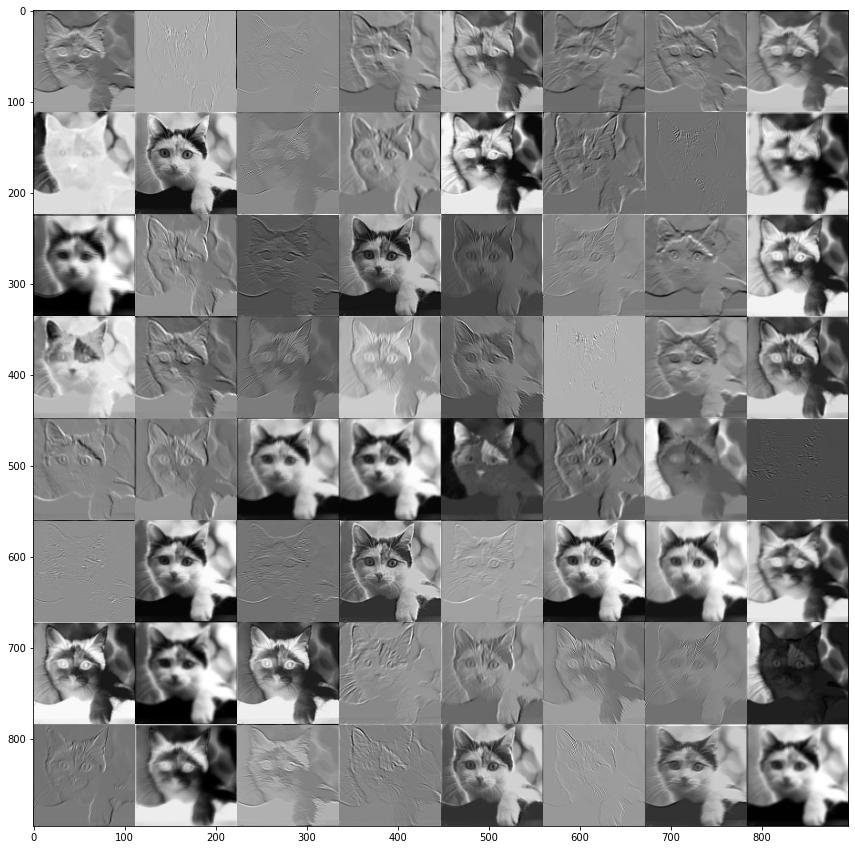

In [66]:
plt.figure(figsize=(15, 15))
plt.imshow(img0, cmap='gray')

### 可视化第二、七个卷积层
对resnet34来说，第2-7个卷积层tensor的shape为64x1x56x56，我们对其2个卷积层输出进行可视化：

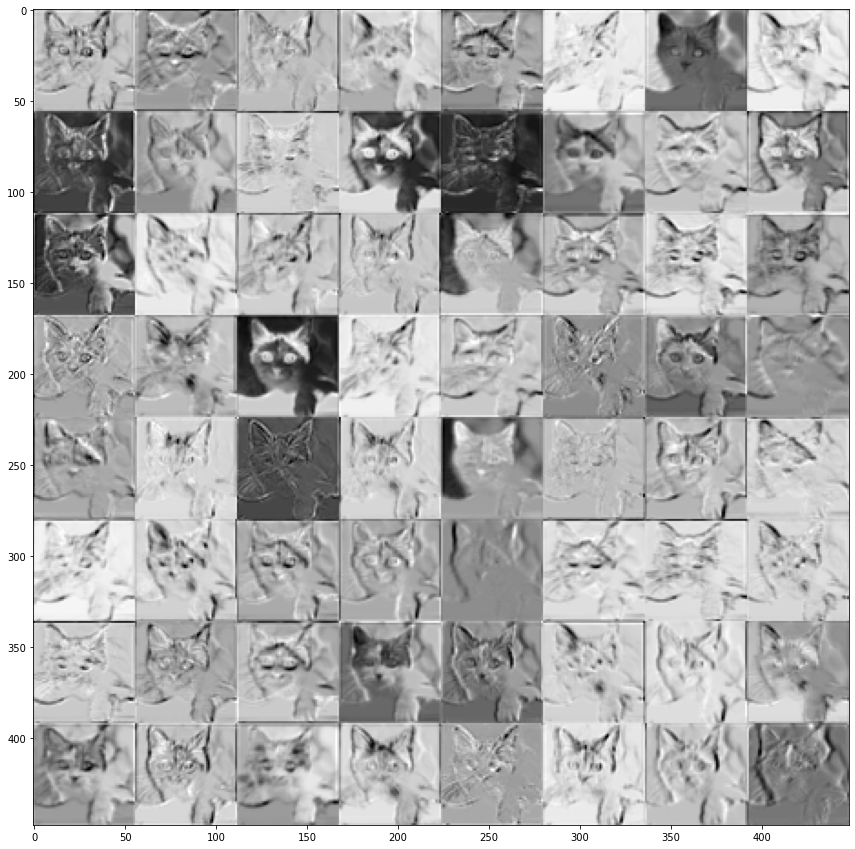

In [63]:
plt.figure(figsize=(15, 15))
plt.imshow(img1, cmap='gray')

第2-7个卷积层tensor的shape为64x1x56x56，我们对第七个卷积层也可视化：

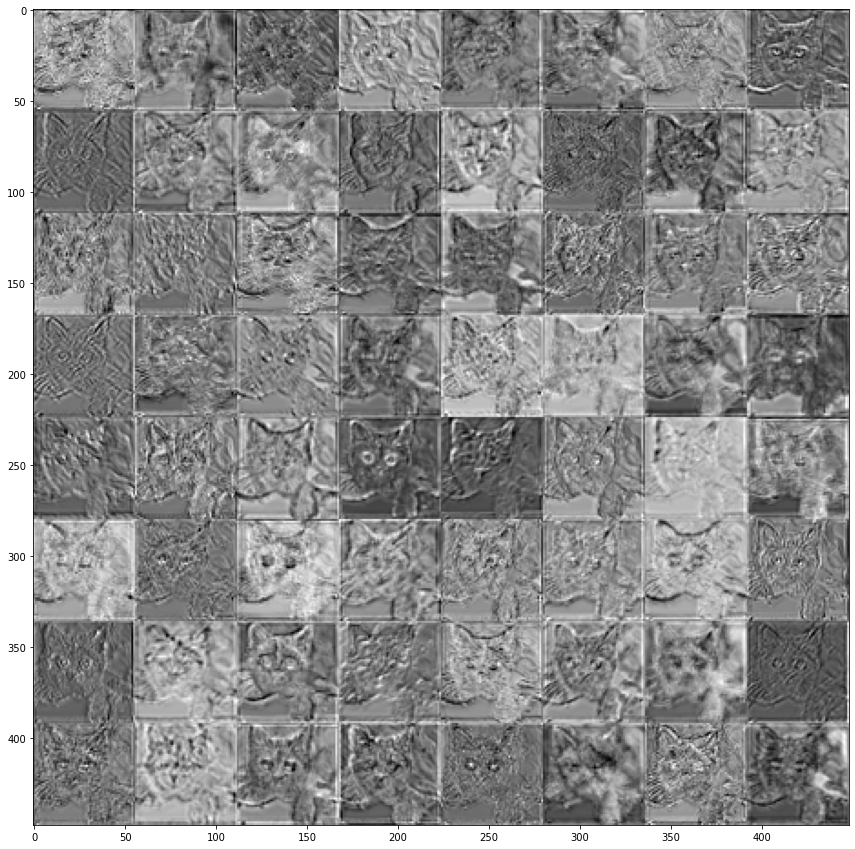

In [64]:
plt.figure(figsize=(15, 15))
plt.imshow(img6, cmap='gray')

### 可视化第16个卷积层

第16个卷积层对应的是conv3_x的结果，其shape为1x128x28x28，可视化如下

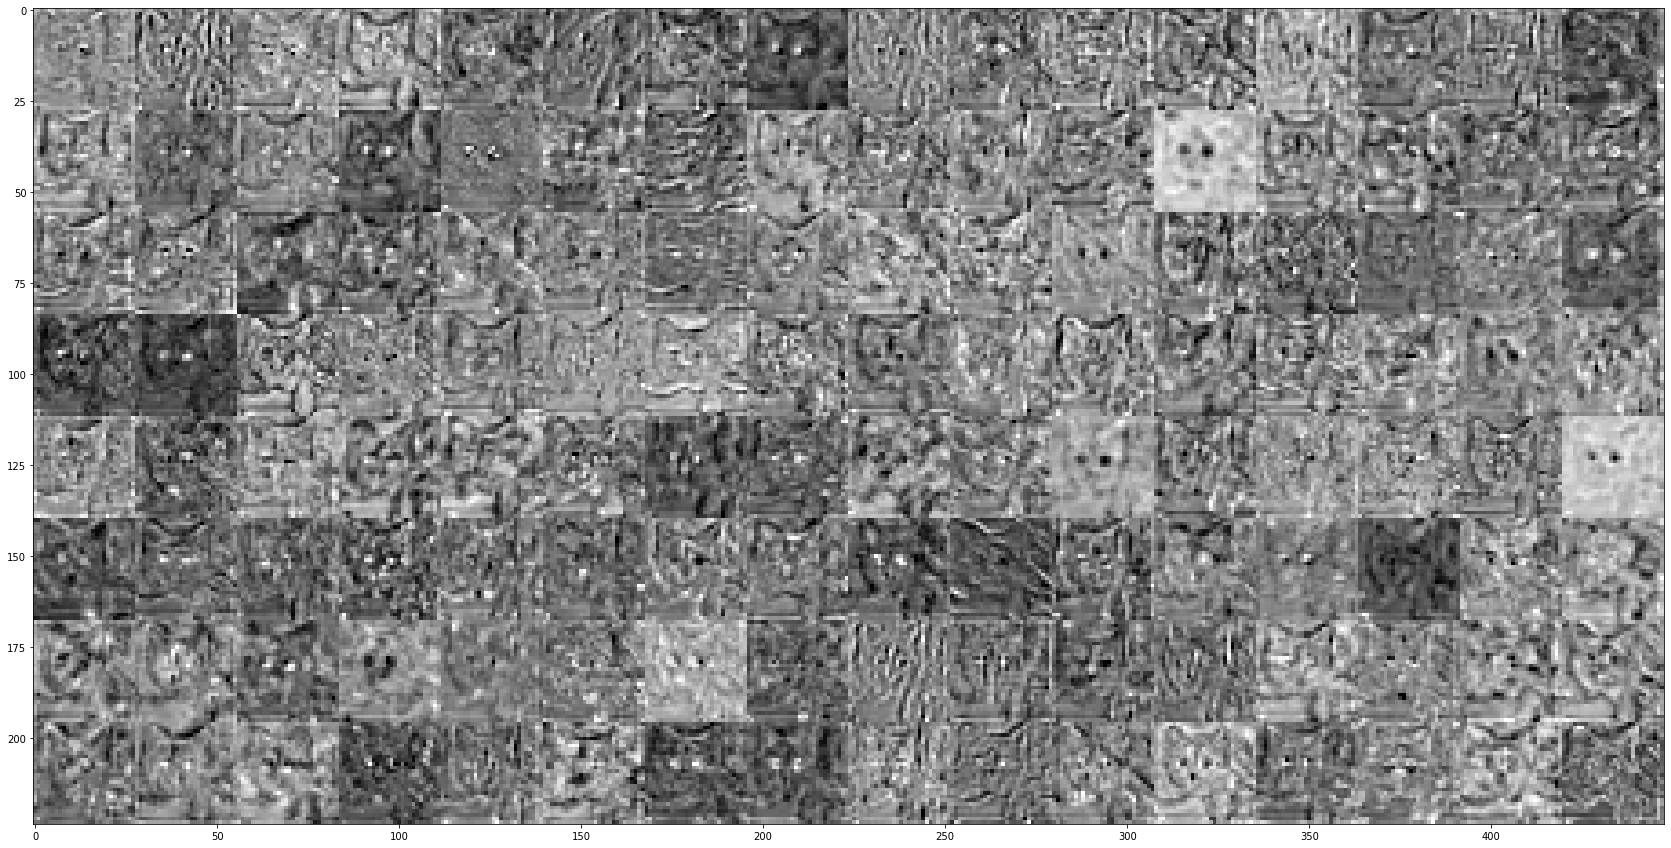

In [65]:
plt.figure(figsize=(30, 15))
plt.imshow(img15, cmap='gray')

### 可视化第29个卷积层
第29个卷积层是conv_4的输出结果（现在每张图片的像素仅为14x14)，我们可视化来看看效果

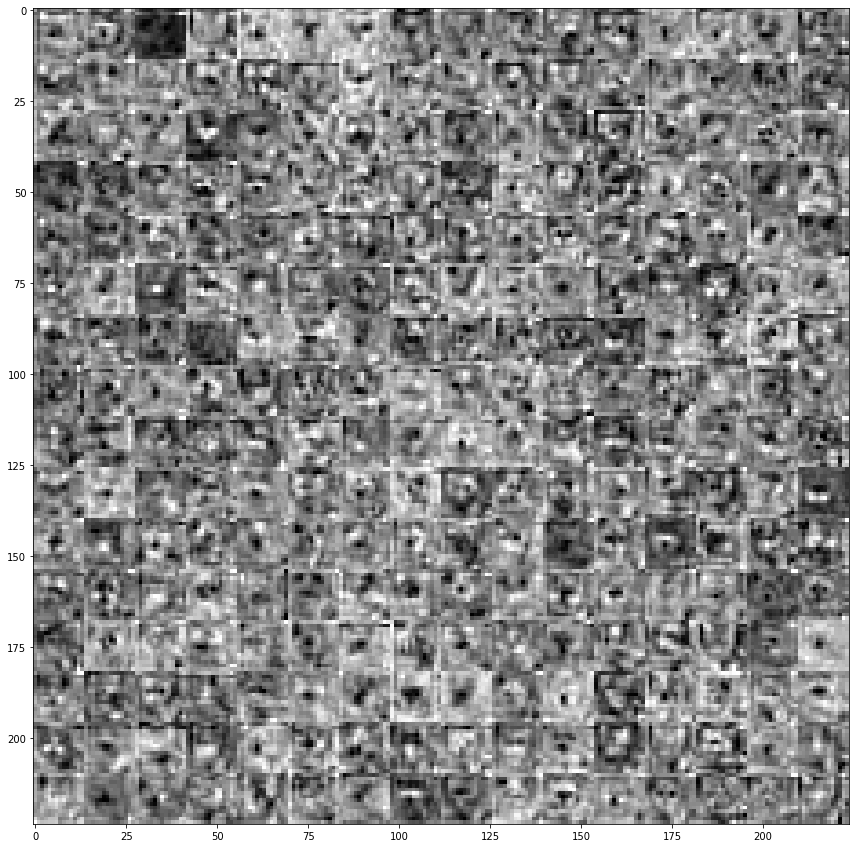

In [73]:
plt.figure(figsize=(15, 15))
plt.imshow(img29, cmap='gray')

## 结语
对神经网络提取结果进行可视化有助于理解其特征提取逐渐高层化的过程。
hook的使用场景还有很多，希望小伙伴们继续探索。